## Coinsidence detection and sound localisation

### Coinsidence detection

* Coinsidence detection is a mechanism that neurones process simultanious signals that comes from various sources.

### Sound localization

* In the contex of sound localization, coinsidence detection is the brain's way of detecting when same sound arrives for both ears at preciesly the right time difference.

[![Coincidence Detection](https://img.youtube.com/vi/BhAadmwZBmE/0.jpg)](https://www.youtube.com/watch?v=BhAadmwZBmE)

<!-- <iframe width="560" height="315" src="https://www.youtube.com/watch?v=BhAadmwZBmE" frameborder="0" allowfullscreen></iframe> -->

## Model

In here we will construct a simplified model of sound localisation carried out by coinsidence detection and delay lines which are inspired by Jeffress model ([more details](http://www.scholarpedia.org/article/Jeffress_model)). 

If there is a sound coming from particular angle $\theta$, it arrives a one ear earlier than the other ear. This difference is called *interaural time difference* or ITD. we use here a sine wave as the signal, at frequency $f$. So, the time difference is ambiguous and becoms an *interaural phase difference* (IPD). The two are related by, $IPD = 2\pi f. ITD$ 

We use [Brian](https://briansimulator.org/) simulator to do this activity.

In [ ]:
try:
    import ipywidgets as widgets
except ImportError:
    widgets = None

try:
    import brian2
except ImportError:
    !pip install brian2

%matplotlib inline
from brian2 import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# prefs.codegen.target = 'numpy'

### Input signal

We'll have the two ears recieve two sine waves with different phase delays, ear 0 will have no delays, and ear 1 will have a delay of `IPD`. Then, we'll have neurons generate spikes as a Poisson process with firing rate `rate_max*0.5*(1+sin(theta))`. We model this in Brian using spike thresold condition `rand()<rate*dt` where `rand()` is a uniform random number in `[0, 1]` and `dt` is the simulation timestep.

interactive(children=(IntSlider(value=100, continuous_update=False, description='rate_max_Hz', step=10), IntSl…

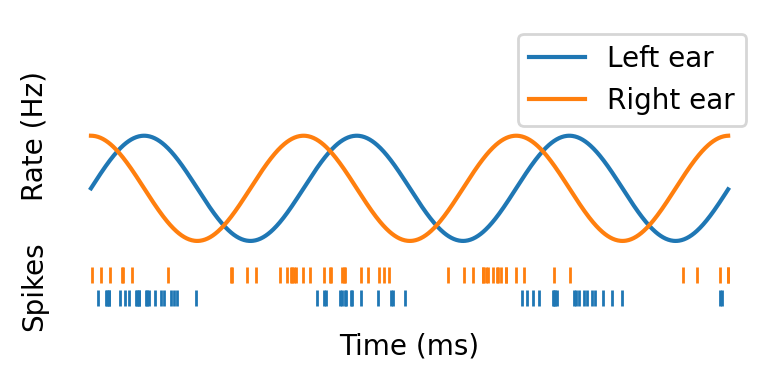

In [45]:
def input_signal(rate_max_Hz=100, ipd_deg=90, f_Hz=3):
    # we cannot use values with units in the widgets, so we add the units first
    rate_max = rate_max_Hz * Hz
    ipd = (pi/180) * ipd_deg  # convert degrees to radians
    f = f_Hz * Hz  # convert frequency to Hz

    '''
    The equations for the ear neurons as follows:
    Use Brian documentation for more details. The `: Hz` at the end of the 
    `rate` equation indicates that the rate is in Hertz, 
    which is a unit of frequency.
    The `: 1` at the end of the `theta` equation indicates that dimensionless.
    Which tells Brian what the units of the variables are.
    The `i` is the index of the neuron, which will be 0 for the neuron 0 and 
    1 for the neuron 1. which allows us to make these two signals different for the two ears.
    '''
    eqs_ears = '''
    theta = 2 * pi * f * t + i * ipd : 1
    rate = rate_max * 0.5 * (1 + sin(theta)) : Hz
    '''
    '''
    We create a group of two neurons with these two equations, that fires a spike 
    according to Poisson process with the given time varing rate. We use a dt of 1ms
    to speed up the simulation. Later we will use better default like 0.1ms.
    '''

    ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt', dt=1*ms)

    # Record the spikes and values of the rate as we run the simulation
    M_spikes = SpikeMonitor(ears)
    M_state = StateMonitor(ears, 'rate', record=True)

    # Run the simulation for 1 second
    run(1 * second)

    # Plot the spikes and the rate
    trains = M_spikes.spike_trains()
    fig = figure(figsize=(4, 2), dpi=200)
    gs = gridspec.GridSpec(2, 1, hspace=0, height_ratios=[1, .3])
    ax = subplot(gs[0])
    plot(M_state.t/ms, M_state.rate[0] / Hz, label='Left ear')
    plot(M_state.t/ms, M_state.rate[1] / Hz, label='Right ear')
    legend(loc='upper right')
    gca().set_frame_on(False)
    ylabel('Rate (Hz)')
    yticks([])
    xticks([])
    ylim(-10, 210)
    subplot(gs[1], sharex=ax)
    plot(trains[0] / ms, [0] * len(trains[0]), '|')
    plot(trains[1] / ms, [1] * len(trains[1]), '|')
    ylim(-1, 2)
    gca().set_frame_on(False)
    xlabel('Time (ms)')
    ylabel('Spikes')
    yticks([])
    xticks([])
    tight_layout()

if widgets is not None:
    widgets.interact(input_signal,
                     rate_max_Hz=widgets.IntSlider(value=100, step=10, continuous_update=False),
                     ipd_deg=widgets.IntSlider(value=90, min=0, max=3600, step=10, continuous_update=False),
                     f_Hz=widgets.FloatSlider(value=3, min=0, max=10, step=1, continuous_update=False))
else:
    input_signal()

### Coincidence detectors

As coincidence detectors, we use $N$ neurons with best delay equally distributed between 0 and $ITD_{max} = \frac{1}{f}$. The coinsidence detector neurons are standared LIF neurons, but we record their best IPD and ITD. Then we create synapses from the ear neurons to the coinsidence detector neuronswhere the synaptic delay is 0 in ear 0 and the best ITD in ear 1. And we use small time constant $\tau$ to get strong coinsidence detection, and plottin purpose.

```text
The Problem Without Windowing
Imagine you have a 1-second simulation with ITD = 50ms:

Left ear: Gets full sine wave from 0-1000ms
Right ear: Gets full sine wave from 0-1000ms, but shifted by 50ms

Issue: The signals have different amounts of content - left ear has 1000ms of signal, right ear effectively has 950ms of "useful" signal that can be compared.

```

interactive(children=(IntSlider(value=400, continuous_update=False, description='rate_max_Hz', max=1000, min=1…

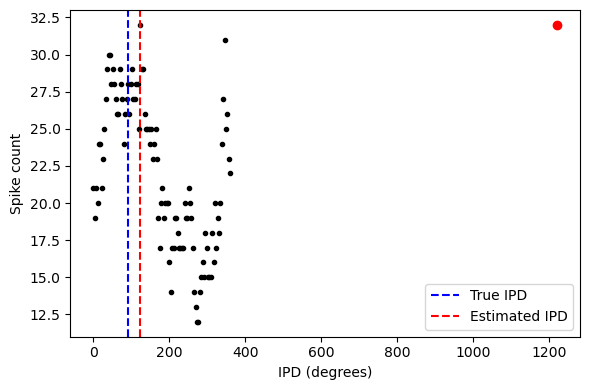

In [ ]:
def localise(rate_max_Hz=400, ipd_deg=200, f_Hz=50, w=0.5, tau_ms=1, N_cd=100, duration=1*second):
    rate_max=rate_max_Hz * Hz # Firing rate in Hz
    ipd = (pi/180) * ipd_deg 
    f = f_Hz * Hz
    tau = tau_ms * ms
    itd = ipd/(2*pi*f)

    # One difference from previous code is that we use edge effect here,
    # by making sure signal is the same on both sides by padding with 
    # rate=rate_max/2 on both sides.(begining/end).
    # the code for this is a bit tricky.
    # (Remember int() function converts boolean (True/False) to 1/0)

    eqs_ears = '''
    theta = 2 * pi * f * t + i * ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max * 0.5 * (1 + signal_is_on * sin(theta)) : Hz
    '''

    ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt')

    # Standared LIF neuron but with best IPD and best ITD that depends on the
    # neuron index (equally distributed in the possible range). 

    eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''
    cd = NeuronGroup(N_cd, eqs_cd, threshold='v > 1', reset='v = 0', method='exact')

    # Synapses from the ears to coincidence detector neurons. If a presynaptic 
    # neuron fires, the post synaptic v value is increased by w.

    S = Synapses(ears, cd, on_pre='v += w')

    # All pre synaptic neurons are connected to all postsynaptic neurons.
    S.connect(p=1)

    # Delays are 0 by default, so we set the delays for where the presynaptic
    # neuron has index 1 (the right ear) to be the best_itd of the post
    # synaptic neuron.

    S.delay['i==1'] = 'best_itd'

    M = SpikeMonitor(cd)
    run(duration)

    # We take as our estimate the mean best IPD of all neurons with 
    # the maximum spike count
    i = max(M.count)
    I = M.count == i
    ipd_est = mean(cd.best_ipd[I])

    # Plot the results
    figure(figsize=(6, 4), dpi=100)
    plot(cd.best_ipd[I]*180*pi, M.count[I], 'or')
    plot(cd.best_ipd*(180/pi), M.count, '.k')
    axvline(ipd_deg, ls='--', c='b', label='True IPD')
    axvline(ipd_est * (180/pi), ls='--', c='r', label='Estimated IPD')
    xlabel('IPD (degrees)') 
    ylabel('Spike count')
    legend(loc='lower right')
    tight_layout()

if widgets is not None:
    widgets.interact(localise,
                     rate_max_Hz=widgets.IntSlider(min=10, max=1000, value=400, step=10, continuous_update=False),
                     ipd_deg=widgets.IntSlider(min=0, max=360, value=90, step=10, continuous_update=False),
                     f_Hz=widgets.IntSlider(min=0, max=200, value=50, step=5, continuous_update=False),
                     w=widgets.FloatSlider(min=.1, max=1, value=.5, step=.1, continuous_update=False),
                     tau_ms=widgets.FloatSlider(min=.1, max=10, value=1, step=.1, continuous_update=False),
                     N_cd=widgets.IntSlider(min=10, max=1000, value=100, step=10, continuous_update=False),
                     duration=widgets.fixed(1*second))
else:
    localise()




### Code Review

#### Initial Parameter Setup
```python
rate_max=rate_max_Hz * Hz # Firing rate in Hz
ipd = (pi/180) * ipd_deg 
f = f_Hz * Hz
tau = tau_ms * ms
itd = ipd/(2*pi*f)
```

These are the initial parameters used to create sine waves, initialized for use with Brian2. The code converts input parameters to appropriate Brian2 units (Hz, radians, seconds, etc.).

#### Ear Neuron Equations
```python
eqs_ears = '''
    theta = 2 * pi * f * t + i * ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max * 0.5 * (1 + signal_is_on * sin(theta)) : Hz
    '''
```

- **`theta`**: Sine wave equation where `i` defines which ear and `ipd` creates the phase delay. The `: 1` means dimensionless (in Brian2 syntax)
- **`signal_is_on`**: Used to trim the two sine waves so we can feed equally time-distributed sine waves for analysis. This handles edge effects by ensuring signals are properly timed.
- **`rate`**: Defines the instantaneous firing rate of a neuron in Hz (not between 0-1, but varies based on the sine wave)

```python
ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt')
```

Creates a neuron group representing 2 ears. They use the previous equations for their behavior. The threshold uses a random number to simulate the stochastic nature of Poisson spike generation.

#### Coincidence Detector Neurons
```python
eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''
```

Defines the equations for coincidence detector neurons:
- **Leaky integrate-and-fire (LIF)** behavior with `dv/dt = -v/tau`
- **`best_ipd`**: Assigns each neuron a particular preferred IPD value to respond to optimally
- **`best_itd`**: Converts the preferred IPD to time delay in seconds

```python
cd = NeuronGroup(N_cd, eqs_cd, threshold='v > 1', reset='v = 0', method='exact')
```

Creates the coincidence detector neuron group with:
- Standard LIF threshold and reset behavior
- **`method='exact'`**: Uses the exact analytical solution for the differential equation (more accurate than numerical methods)

#### Synaptic Connections
```python
S = Synapses(ears, cd, on_pre='v += w')
S.connect(p=1)
```

Defines synapses from ear neurons to coincidence detection neurons, creating (2 × N_cd) connections. When a presynaptic neuron fires, the postsynaptic membrane potential increases by `w`. All connections are made with 100% probability.

```python
S.delay['i==1'] = 'best_itd'
```

Sets synaptic delays: left ear (i==0) has default 0 delay, while right ear (i==1) connections have delays equal to each CD neuron's `best_itd`.

#### Simulation and Analysis
```python
M = SpikeMonitor(cd)
run(duration)
```

Monitors and records spike firing of the CD neuron group, then runs the simulation.

```python
i = max(M.count)           # Find the maximum spike count among all CD neurons
I = M.count == i           # Create boolean array: True for neurons with max count  
ipd_est = mean(cd.best_ipd[I])  # Average best_ipd values of most active neurons
```

**Analysis logic**: The coincidence detector neuron(s) whose preferred IPD best matches the actual signal IPD will fire most frequently due to optimal coincidence detection. The code finds these most-active neurons and estimates the IPD by averaging their `best_ipd` values.

### Evaluation

Let's see how well the model perform. We'll run it once for each IPD from 0 to 360 degrees in steps of 10 degrees, and plot estimated IPDs and errors as a function of IPD, and compute the mean error.

The first function computes the input signal and returns the spike times. The second function estimates the IPD from it.

In [47]:
rate_max = 400 * Hz
f = 50 * Hz
duration = 1 * second
w = 0.5
tau = 1 * ms
N_cd = 100

In [48]:
# This one generates an input signal and returns a pair (i, t) of arrays with i 
# the spike indices (0 or 1 since there are 2 neurons) and t the corresponding spike times.

def generate_input_signal(ipd):
    itd = ipd/(2*pi*f)

    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    signal_is_on = int(t<duration-itd)*int(i==0)+int(t>itd)*int(i==1) : 1
    rate = rate_max * 0.5 * (1 + signal_is_on * sin(theta)) : Hz
    '''
    ears = NeuronGroup(2, eqs_ears, threshold='rand() < rate * dt')
    M = SpikeMonitor(ears)
    run(duration)

    return M.i, M.t

In [49]:
# this one performs the localization from before, using just those arrays
# returned by the previous function, which we convert into a group of neurons
# in Brian using SpikeGeneratorGroup.

def localise_from_input(i, t):
    ears = SpikeGeneratorGroup(2, i, t) # Create a group of neurons from the spike times

    eqs_cd = '''
    dv/dt = -v/tau : 1
    best_ipd = 2*pi*i/(N_cd-1) : 1
    best_itd = best_ipd/(2*pi*f) : second
    '''

    cd = NeuronGroup(N_cd, eqs_cd, threshold='v > 1', reset='v = 0', method='exact')

    S = Synapses(ears, cd, on_pre='v += w')
    S.connect(p=1)
    S.delay['i==1'] = 'best_itd'

    M = SpikeMonitor(cd)
    run(duration)

    i = max(M.count)
    I = M.count == i
    ipd_est = mean(cd.best_ipd[I]) # Average best_ipd values of most active neurons

    return ipd_est

In [50]:
i, t = generate_input_signal(90)
ipd_est = localise_from_input(i, t)
print(ipd_est)  

1.9039955476301778


In [51]:
def generate_and_localise(ipd, localiser):
    i, t = generate_input_signal(ipd)
    return localiser(i, t)

def generate_results(localiser):
    ipds = arange(0, 360, 10) * (pi/180)  # IPDs in radians
    ipds_est = array([generate_and_localise(ipd, localiser) for ipd in ipds])
    return ipds, ipds_est

ipds, ipds_est = generate_results(localise_from_input)

In [52]:
ipds

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
       1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
       2.61799388, 2.7925268 , 2.96705973, 3.14159265, 3.31612558,
       3.4906585 , 3.66519143, 3.83972435, 4.01425728, 4.1887902 ,
       4.36332313, 4.53785606, 4.71238898, 4.88692191, 5.06145483,
       5.23598776, 5.41052068, 5.58505361, 5.75958653, 5.93411946,
       6.10865238])

In [53]:
ipds_est

array([3.25265906, 0.44426563, 3.84607101, 0.03173326, 0.57119866,
       6.28318531, 0.27502158, 1.45972992, 0.50773215, 1.96746207,
       1.84052903, 1.84052903, 1.61839622, 2.22132814, 1.65012947,
       2.15786162, 2.98292636, 3.01465962, 3.01465962, 3.55412502,
       4.1887902 , 3.99839065, 3.30025895, 3.93492413, 4.12532369,
       3.39545873, 4.12532369, 4.97154393, 4.25225672, 5.36292079,
       4.91865516, 5.87065294, 6.09278575, 0.28559933, 0.        ,
       5.83891968])

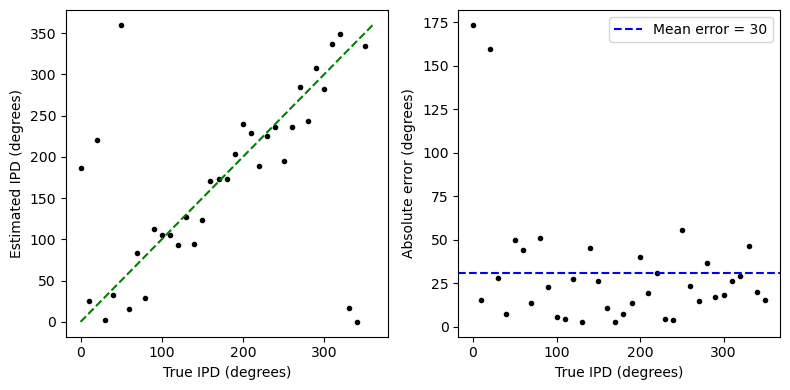

In [54]:
# Mean error should be calculated in a circular fasion
# Giving 359 degrees when answer is 0 is 1 degree not 359
# So, compute +-360 deg and take the minimum
def compute_errors(ipds, ipds_est):
    ipds_est_circ = array([ipds_est, ipds_est+2*pi, ipds_est-2*pi])
    abs_errors_circ = abs(ipds[newaxis, : ] - ipds_est_circ)
    abs_error_deg = amin(abs_errors_circ, axis=0) * (180/pi)  # Convert to degrees
    return abs_error_deg

def plot_results(ipds, ipds_est):
    abs_errors_deg = compute_errors(ipds, ipds_est)
    figure(figsize=(8, 4), dpi=100)
    subplot(121)
    plot(ipds*180/pi, ipds_est*180/pi, '.k')
    plot([0, 360], [0, 360], '--g')
    xlabel('True IPD (degrees)')
    ylabel('Estimated IPD (degrees)')
    subplot(122)
    plot(ipds*180/pi, abs_errors_deg, '.k')
    mean_abs_error_deg = mean(abs_errors_deg)
    axhline(mean_abs_error_deg, ls='--', c='b', label=f'Mean error = {int(mean_abs_error_deg)}')
    xlabel('True IPD (degrees)')
    ylabel('Absolute error (degrees)')
    legend(loc='best')
    tight_layout()

plot_results(ipds, ipds_est)

### Exercise

Can you do better than the network above? Limit yourself to only 100 neurons, and use the `generate_input_signal` function from above to generate the input data, but otherwise feel free to do whatever you like. Some ideas:

Optimise the parameters `tau, w`
Use a different neuron model
Use a different method to estimate the IPD given the set of coincidence detector neuron counts

1. let's create same model to get different `tau, w` values and plot the errors

### References

* [Github](https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/2-coincidence-detection.ipynb)